# Cobalt prediction on Naive Bayes

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


In [2]:
filepath = "Merged_Ni_lessthan15km.csv"
df = pd.read_csv(filepath)

### View the data

In [3]:
df.head(5)

,Unnamed: 0,Unnamed: 0_x,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,lat,long,Unnamed: 0_y,minedex_coords,minedex_site,wamex_lat,wamex_lon,distance
0,0,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46661,"(-17.34893, 128.022095)",S0001442,-17.234642,128.032146,12.693593881734987 km
1,1,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46662,"(-17.31078, 128.023499)",S0002890,-17.234642,128.032146,8.476376684524638 km
2,2,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46663,"(-17.3526, 128.027695)",S0019720,-17.234642,128.032146,13.063277176872425 km
3,3,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46664,"(-17.3526, 128.027695)",S0019821,-17.234642,128.032146,13.063277176872425 km
4,4,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46665,"(-17.338411, 128.017007)",S0231765,-17.234642,128.032146,11.59661465949521 km


In [4]:
df.shape

(150625, 20)

### Get unique values

In [5]:
df_unique = df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'lat', 'long', 
                     'minedex_coords', 'minedex_site',
                    'distance','wamex_lat','wamex_lon','Unnamed: 0'])

df_unique = df_unique.drop_duplicates()

In [6]:
df_unique.head(5)

,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag
0,56.0,420.0,9.0,14.0,0.010,1.0,NaN,NaN,NaN,NaN
5,31.0,195.0,6.0,10.0,0.007,1.0,NaN,NaN,NaN,NaN
10,90.0,150.0,15.0,2.0,0.004,0.5,NaN,NaN,NaN,NaN
15,37.0,135.0,11.0,4.0,0.005,1.0,NaN,NaN,NaN,NaN
18,58.0,120.0,14.0,5.0,0.004,0.5,NaN,NaN,NaN,NaN


In [7]:
df_unique.shape

(22876, 10)

### Dsta cleaning

In [8]:
df_unique.isnull().sum()

Ni        0
Cu      158
Co        0
Pd    11812
Au     4025
Pt    11948
Rh    21033
Fe     7859
S     11563
Ag     7328
dtype: int64

In [9]:
df_unique = df_unique.drop(['Pd', 'Pt','Rh','S'], axis=1)

In [10]:
df_unique.head(5)

,Ni,Cu,Co,Au,Fe,Ag
0,56.0,420.0,9.0,0.010,NaN,NaN
5,31.0,195.0,6.0,0.007,NaN,NaN
10,90.0,150.0,15.0,0.004,NaN,NaN
15,37.0,135.0,11.0,0.005,NaN,NaN
18,58.0,120.0,14.0,0.004,NaN,NaN


In [11]:
def replace_neg9999(val):
    if val == -9999: 
        return 0
    else:
        return val
    
    
def abs_halve_neg_val(val):
    if val < 0:
        return abs(val) / 2
    else: 
        return val

def clean_assays(df):
    df = df.applymap(replace_neg9999)
    df = df.applymap(abs_halve_neg_val)
    
    return df

In [12]:
df_new = clean_assays(df_unique)
df_new = df_new.dropna()
df_new.shape

(9549, 6)

In [13]:
df_new.head

<bound method NDFrame.head of              Ni      Cu     Co     Au       Fe    Ag
106       182.2    65.0   64.0  0.001   4930.0  0.05
109       247.2    77.3   62.0  0.001   5600.0  0.05
112       179.6    60.9   40.0  0.001   4810.0  0.05
115        97.6    21.7   45.0  0.001   4420.0  0.05
193        63.0   118.0   20.0  0.006  11400.0  0.50
...         ...     ...    ...    ...      ...   ...
134162    100.0   200.0   30.0  0.010  15200.0  1.00
135965   1200.0  3500.0   20.0  0.010  50300.0  0.25
136098    800.0  2250.0   20.0  0.010  48600.0  0.25
143779   1200.0  1500.0   35.0  0.005  50000.0  0.50
146055  22000.0  1050.0  920.0  0.010  26700.0  1.00

[9549 rows x 6 columns]>

### Modeling
#### Set catogrical value for classifier

<AxesSubplot:ylabel='Frequency'>

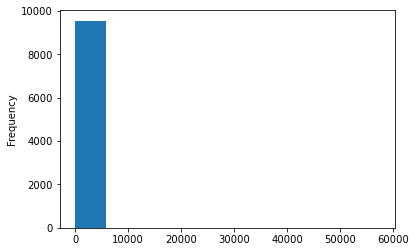

In [14]:
df_new['Co'].plot(kind='hist')

#### The average level of cobalt in soils is 8 ppm, consider observation with cobalt > 8 ppm abundance 

In [15]:
# if the level of cobalt > 8, we consider it as abundance
def if_abundance(val):
    if val > 8:
        return 1
    else:
        return 0

In [16]:
df_new['Co'] = df_new['Co'].apply(if_abundance)
df_new.head(5)

,Ni,Cu,Co,Au,Fe,Ag
106,182.2,65.0,1,0.001,4930.0,0.05
109,247.2,77.3,1,0.001,5600.0,0.05
112,179.6,60.9,1,0.001,4810.0,0.05
115,97.6,21.7,1,0.001,4420.0,0.05
193,63.0,118.0,1,0.006,11400.0,0.50


<AxesSubplot:ylabel='Frequency'>

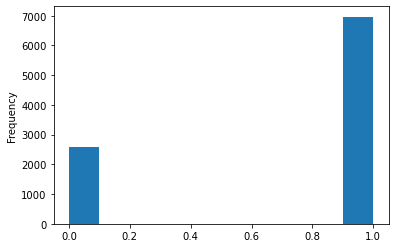

In [17]:
df_new['Co'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

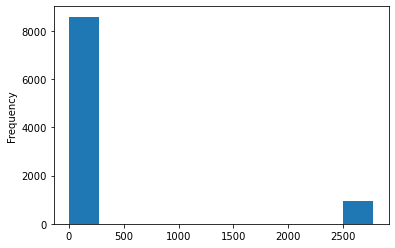

In [18]:
df_new['Au'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

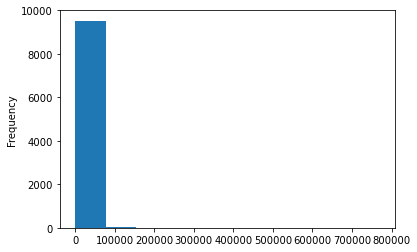

In [19]:
df_new['Cu'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

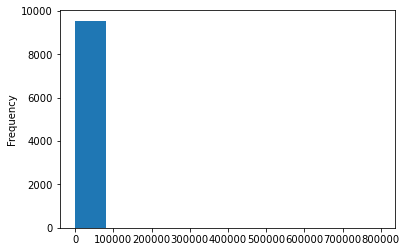

In [20]:
df_new['Fe'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

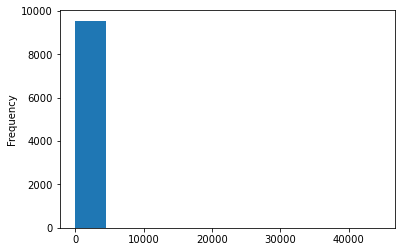

In [21]:
df_new['Ag'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

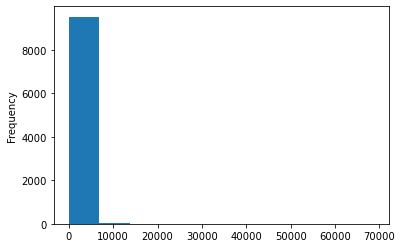

In [22]:
df_new['Ni'].plot(kind='hist')

#### Gaussian Naive Bayes

In [23]:
df_new.target = df_new.loc[:, ["Co"]]
df_new.target.shape

<ipython-input-23-67c5a28c2712>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_new.target = df_new.loc[:, ["Co"]]


(9549, 1)

In [24]:
df_new.target = df_new['Co']

In [25]:
df_new.data = df_new.drop(['Co'],axis=1)
df_new.data.shape

<ipython-input-25-ea362a75f885>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_new.data = df_new.drop(['Co'],axis=1)


(9549, 5)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_new.data, df_new.target, test_size=0.3,random_state=109) # 70% training and 30% test

In [27]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [28]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test,y_pred))

Accuracy: 0.4572425828970332
Precision: 0.9498327759197325
Recall: 0.2713807931199236
F1 Score: 0.42214790040877004


#### Multinomial Naive Bayes - produce better result somehow

In [29]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test,y_pred))

Accuracy: 0.712739965095986
Precision: 0.7367636092468307
Recall: 0.9440993788819876
F1 Score: 0.8276439790575917


### Log transformation

In [30]:
def log_transform (var):
    return np.log(var + 1) 

In [31]:
df_new.datalog = df_new.data.applymap(log_transform)
df_new.datalog.head(5)


<ipython-input-31-78a408541bbc>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_new.datalog = df_new.data.applymap(log_transform)


,Ni,Cu,Au,Fe,Ag
106,5.210578,4.189655,0.001000,8.503297,0.048790
109,5.514235,4.360548,0.001000,8.630700,0.048790
112,5.196285,4.125520,0.001000,8.478660,0.048790
115,4.591071,3.122365,0.001000,8.394121,0.048790
193,4.158883,4.779123,0.005982,9.341456,0.405465


In [32]:
df_new.datalog.describe

<bound method NDFrame.describe of               Ni        Cu        Au         Fe        Ag
106     5.210578  4.189655  0.001000   8.503297  0.048790
109     5.514235  4.360548  0.001000   8.630700  0.048790
112     5.196285  4.125520  0.001000   8.478660  0.048790
115     4.591071  3.122365  0.001000   8.394121  0.048790
193     4.158883  4.779123  0.005982   9.341456  0.405465
...          ...       ...       ...        ...       ...
134162  4.615121  5.303305  0.009950   9.629116  0.693147
135965  7.090910  8.160804  0.009950  10.825780  0.223144
136098  6.685861  7.719130  0.009950  10.791399  0.223144
143779  7.090910  7.313887  0.004988  10.819798  0.405465
146055  9.998843  6.957497  0.009950  10.192456  0.693147

[9549 rows x 5 columns]>

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_new.datalog, df_new.target, test_size=0.3, random_state=109) # 70% training and 30% test

#### Apply Gussian 

In [34]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test,y_pred))

Accuracy: 0.7703315881326352
Precision: 0.8863758750673129
Recall: 0.7864309603440038
F1 Score: 0.8334177215189874


#### Apply Multinomial

In [35]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test,y_pred))

Accuracy: 0.7319371727748691
Precision: 0.7363539065287192
Recall: 0.9861442904921166
F1 Score: 0.8431372549019607


### Apply logistic regression (best fit)

In [36]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

In [37]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 529,  243],
       [  97, 1996]])

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

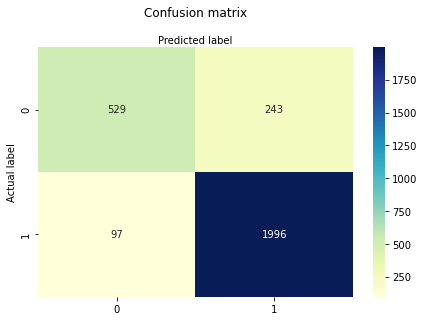

In [39]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [40]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test,y_pred))

Accuracy: 0.881326352530541
Precision: 0.8914694059848146
Recall: 0.9536550406115624
F1 Score: 0.9215143120960295


### Add lat and long

In [41]:
df_loc = df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 
                     'minedex_coords', 'minedex_site',
                    'distance','wamex_lat','wamex_lon','Unnamed: 0', 'Pd', 'Pt','Rh','S'])

In [42]:
df_loc.shape

(150625, 8)

In [43]:
df_loc = df_loc.drop_duplicates()
df_loc.shape

(23062, 8)

In [44]:
df_loc = clean_assays(df_loc)
df_loc = df_loc.dropna()
df_loc.shape

(9527, 8)

In [45]:
df_loc['Co'] = df_loc['Co'].apply(if_abundance)

In [46]:
df_loc.target = df_loc['Co']
df_loc.data = df_loc.drop(['Co'],axis=1)

<ipython-input-46-b8b49d2a6045>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_loc.target = df_loc['Co']
<ipython-input-46-b8b49d2a6045>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_loc.data = df_loc.drop(['Co'],axis=1)


In [47]:
df_loc.log = df_loc.data.applymap(log_transform)

<ipython-input-47-84e733c2ee2f>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_loc.log = df_loc.data.applymap(log_transform)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_loc.data, df_loc.target, test_size=0.3, random_state=109) # 70% training and 30% test

In [49]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test,y_pred))

Accuracy: 0.5127667016439315
Precision: 0.9406565656565656
Recall: 0.3562888570062171
F1 Score: 0.5168227540756156


### Best Bayes so far

In [50]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test,y_pred))

Accuracy: 0.7754459601259182
Precision: 0.7873859579531932
Recall: 0.9493065518890483
F1 Score: 0.8607979184735474


## Logistic Regression

In [51]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

/Users/xiaohan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 257.44, 'Predicted label')

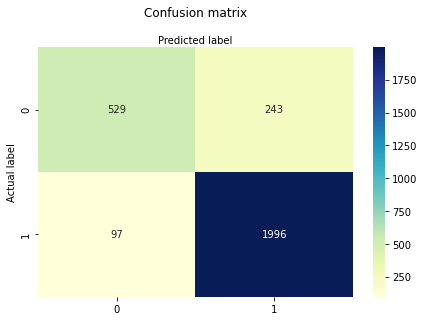

In [52]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [53]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test,y_pred))

Accuracy: 0.7796432318992654
Precision: 0.7828106852497096
Recall: 0.9670014347202296
F1 Score: 0.865211810012837
